# Proof of Concept: Unsupervised Anomaly Detection for Check Kiting Fraud

## Business Context

Check kiting is a fraudulent scheme in which individuals exploit the delay in check clearance—known as "float"—to create artificially inflated account balances. This is typically done by writing checks between multiple accounts and rapidly moving funds before the original checks clear. These behaviors are subtle, fast-moving, and difficult to detect using traditional rule-based systems or supervised models, which often rely on labeled fraud data.

In real-world banking environments, labeled fraud data may be sparse or delayed. Unsupervised anomaly detection allows institutions to identify suspicious behavioral patterns based on deviations from expected norms—making it a valuable tool in early-stage fraud detection and financial crime prevention.

## Business Goal

The objective of this project is to simulate a real-world fraud analytics workflow using unsupervised learning to detect potential check kiting behavior. We apply an Isolation Forest model to flag anomalous transactions or accounts based on patterns such as transaction velocity, transfer frequency, and irregular timing—without using any fraud labels during training.

This approach aims to prioritize cases for investigation and enhance early fraud detection in environments where labeled fraud examples are not available.

## Dataset Overview

We use the **BankSim Synthetic Dataset**, which simulates real-world banking transactions and includes features such as customer IDs, transaction time steps, amounts, and merchant categories.

| Feature        | Description                                                 |
|----------------|-------------------------------------------------------------|
| `step`         | Time of transaction (in hours since start of simulation)    |
| `customer`     | Unique anonymized customer ID                               |
| `age`, `gender`| Customer demographic features                               |
| `merchant`     | Receiving merchant                                           |
| `category`     | Transaction category (e.g., bills, travel, transfer)        |
| `amount`       | Transaction amount                                           |
| `fraud`        | Binary label: 0 = legitimate, 1 = fraud (used for evaluation only) |

> Note: While the dataset includes a `fraud` column, it is **not used during model training**. It is only used for post-model evaluation to benchmark anomaly detection performance.

> This dataset is sourced from a public Kaggle repository and is fully synthetic — no real customer data is used.

## Tools and Techniques

- **Python** (Pandas, NumPy): For data preprocessing and feature engineering  
- **Matplotlib / Seaborn**: For exploratory data analysis and visualizations  
- **Scikit-learn**: For building the Isolation Forest anomaly detection model  
- **Evaluation**: Post-hoc validation of flagged anomalies against known fraud labels

## Intended Audience

This notebook is intended for:

- Data scientists and machine learning practitioners developing fraud detection models  
- Fraud and risk analysts looking to explore unsupervised learning methods  
- Fintech professionals and compliance teams seeking scalable anomaly detection strategies  
- Recruiters and hiring managers evaluating applied machine learning project work


## Step 1: Load and Examine the Dataset

We begin by loading the **BankSim dataset**, which contains over 590,000 simulated banking transactions. Before building any models, it’s essential to explore and understand the structure of the dataset.


In [ ]:
import pandas as pd

df = pd.read_csv('banksim.csv')
print(df.head())
print(df.info())
df['fraud'].value_counts(normalize=True)

   step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1     0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2     0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3     0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4     0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   

              category  amount  fraud  
0  'es_transportation'    4.55      0  
1  'es_transportation'   39.68      0  
2  'es_transportation'   26.89      0  
3  'es_transportation'   17.25      0  
4  'es_transportation'   35.72      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          59

fraud
0    0.987892
1    0.012108
Name: proportion, dtype: float64

### Why This Step Is Important:
- `df.head()` shows the first few rows so we can confirm the dataset loaded properly and inspect individual features.

- `df.info()` helps us understand:

    - The number of entries (594,643)

    - The data types of each column (e.g., integer, float, object)

    - Whether there are any missing values (none found — great!)

- `value_counts(normalize=True)` helps us measure the proportion of fraudulent transactions.

### Key Observations:
- ✅ The dataset has 594,643 transactions with 10 columns.

- ✅ There are no missing values in any column.

- ✅ Only ~1.2% of transactions are labeled as fraudulent (fraud = 1), which is consistent with the real-world rarity of financial fraud.

## 🧹 Step 2: Clean and Prepare the Dataset

Before we can apply any machine learning models, we need to clean and structure the dataset for analysis.

In this step, we will:

- Drop non-informative or high-cardinality columns
- Encode categorical variables into numeric format
- Prepare the data for feature engineering and modeling

---

### 🧼 What We’re Doing:

Some columns like `customer`, `merchant`, `zipcodeOri`, and `zipMerchant` contain unique or semi-unique identifiers that do not carry meaningful predictive value for anomaly detection. Including them could introduce noise or overfitting, so we remove them.

Next, we convert the remaining categorical columns (`category`, `age`, `gender`) into numeric codes using `.astype('category').cat.codes`. This is necessary because machine learning algorithms typically require numerical input.

---

### 🧠 Why This Step Matters:

- Dropping ID-like columns helps prevent the model from learning **account-specific patterns** rather than **behavioral signals**.
- Encoding categorical variables allows us to feed the data into algorithms like **Isolation Forest** later on.
- This step ensures we keep only the features that describe **transactional behavior**, which is what anomaly detection is designed to evaluate.

---

> Once this step is complete, we’ll be ready to engineer features that reveal potential check kiting activity.


In [ ]:
df_cleaned = df.drop(['customer', 'merchant', 'zipcodeOri', 'zipMerchant'], axis=1)
df_cleaned['category'] = df_cleaned['category'].astype('category').cat.codes
df_cleaned['gender'] = df_cleaned['gender'].astype('category').cat.codes
df_cleaned['age'] = df_cleaned['age'].astype('category').cat.codes

print(df_cleaned.head())

   step  age  gender  category  amount  fraud
0     0    4       2        12    4.55      0
1     0    2       2        12   39.68      0
2     0    4       1        12   26.89      0
3     0    3       2        12   17.25      0
4     0    5       2        12   35.72      0


### 💡 Explanation:
- **Dropped Columns:**

    - `customer`, `merchant`, `zipcodeOri`, and `zipMerchant` are dropped because they serve as unique or semi-unique IDs.

    - These features don't generalize across accounts and might bias the model toward memorizing patterns instead of detecting behavioral anomalies.

- **Encoded Categorical Features:**

    - `category`, `gender`, and `age` are originally string/object types.

    - These are converted into numerical codes using `.astype('category').cat.codes` so they can be used by the machine learning model.

### 👀 Output Review:
The `df_cleaned.head()` output shows that all variables are now numeric. For example:

- `'F'` and `'M'` in gender have become values like 0 and 1.

- Each category (e.g., `es_transportation`) is represented by a number (e.g., 12).

- The dataset now includes only meaningful, numeric fields that describe **behavior**, not identity.



## 🧮 Step 3: Create Customer-Level Behavioral Features

To identify check kiting fraud, we need to detect **unusual behavioral patterns** at the account level, not just individual transactions.

Check kiting typically involves:
- A **high volume of transactions**
- Repeated movement of money in **short, predictable time intervals**
- **Low variability** in transaction amounts (to maintain the illusion of stability)
- Significant **total volume** of money transferred

---

### 🛠️ What This Code Does

We aggregate the transaction data by customer using `.groupby('customer').agg(...)`, calculating:

- `tx_count`: Number of total transactions per customer
- `tx_step_std`: Standard deviation in time (`step`) — lower values suggest regular, repetitive behavior
- `tx_sum`: Total amount moved
- `tx_avg`: Average transaction amount
- `tx_amt_std`: Standard deviation of transaction amounts — lower variability may indicate scripting or cycling behavior




In [ ]:
# NOTE: If you've dropped 'customer' already, you'll need to do this BEFORE dropping it

# Reload original data with customer included, if necessary
df_raw = pd.read_csv('banksim.csv')

# Aggregate features by customer
features = df_raw.groupby('customer').agg({
    'step': ['count', 'std'],
    'amount': ['sum', 'mean', 'std']
}).reset_index()

# Rename columns for readability
features.columns = ['customer', 'tx_count', 'tx_step_std', 'tx_sum', 'tx_avg', 'tx_amt_std']

# Preview results
features.head()

,customer,tx_count,tx_step_std,tx_sum,tx_avg,tx_amt_std
0,'C1000148617',131,40.826652,4597.04,35.091908,36.863536
1,'C100045114',109,43.704938,9846.65,90.336239,381.812802
2,'C1000699316',94,35.752001,3586.56,38.154894,41.544414
3,'C1001065306',30,43.885496,6142.64,204.754667,306.240251
4,'C1002658784',131,42.194366,4487.18,34.253282,27.820062


### 📊 Commentary on the Output

- Some accounts (e.g., C1001065306) show very high average amounts with low transaction counts, suggesting concentrated high-value activity.

- Others (like C1000148617) have many smaller transactions with moderate variability.

- Accounts with low `tx_step_std` and `low tx_amt_std` may be engaging in systematic, suspicious behavior, a pattern consistent with check kiting schemes.

## 🤖 Step 4: Train Isolation Forest for Anomaly Detection

Now that we’ve engineered customer-level behavioral features, we’ll apply an **unsupervised machine learning algorithm** to flag anomalous activity.

---

### 🌲 What is Isolation Forest?

Isolation Forest is an anomaly detection model that works by **randomly splitting features** to isolate observations. It’s especially well-suited for large datasets and skewed distributions like fraud detection.

- Normal data points take **more steps to isolate**
- Anomalous points are **isolated quickly** and flagged as outliers

---



In [ ]:
from sklearn.ensemble import IsolationForest

# Initialize model with small expected contamination rate (~0.5%)
model = IsolationForest(n_estimators=100, contamination=0.005, random_state=42)

# Train the model on all behavioral features
model.fit(features.drop('customer', axis=1))

# Predict anomalies: -1 = outlier, 1 = inlier
features['anomaly'] = model.predict(features.drop('customer', axis=1))

print(features['anomaly'].value_counts())
features.head()

anomaly
 1    4091
-1      21
Name: count, dtype: int64


,customer,tx_count,tx_step_std,tx_sum,tx_avg,tx_amt_std,anomaly
0,'C1000148617',131,40.826652,4597.04,35.091908,36.863536,1
1,'C100045114',109,43.704938,9846.65,90.336239,381.812802,1
2,'C1000699316',94,35.752001,3586.56,38.154894,41.544414,1
3,'C1001065306',30,43.885496,6142.64,204.754667,306.240251,1
4,'C1002658784',131,42.194366,4487.18,34.253282,27.820062,1


### ✅ Model Output Interpretation

After fitting the **Isolation Forest** model, we review the predictions by printing the `anomaly` column values and previewing the updatedatasets.

🔎 What the Output Tells Us:

- 1 indicates normal accounts — 4,091 customers were not flagged.

- -1 indicates anomalous accounts — only 21 customers were flagged as suspicious.

This matches the contamination=0.005 parameter we passed earlier (0.5% of ~4,112 total customers ≈ 20).t:


### 🧠 Interpreting the `features.head()` Output

We now have a new column: `anomaly`, which contains the model's prediction for each account.

| customer      | tx_count | tx_step_std | tx_sum  | tx_avg | tx_amt_std | anomaly |
|---------------|----------|-------------|---------|--------|-------------|---------|
| C1000148617   | 131      | 40.83       | 4597.0  | 35.1   | 36.9        | 1       |
| C1000405114   | 47       | 43.70       | 984.7   | 20.9   | 381.8       | 1       |
| ...           | ...      | ...         | ...     | ...    | ...         | ...     |

Each row now tells us not only **how a customer behaves**, but also whether that behavior is considered:
- `1`: **Normal** by the model
- `-1`: **Anomalous** (potentially suspicious)

---

### ⚠️ Why This Is Useful

- **Check kiting is a behavioral fraud.**
  - It does not appear suspicious in a single transaction.
  - It becomes suspicious when seen as a pattern: frequent, regular, and repetitive activity.

- **Isolation Forest** helps us **automatically detect these behavioral outliers**, without needing labeled fraud examples.

- The accounts marked with `anomaly = -1` are now our **fraud candidates**, flagged <u>solely by their transactional behavior; not by any prior fraud label.</u>

> In the next step, we’ll **visualize the differences** between normal and anomalous accounts so we can better understand what the model is seeing; and explain its decisions to others.


## 📊 Visualizing Transaction Patterns for Anomalies

To understand why certain accounts were flagged as anomalous, we can visualize how their **average transaction amount (`tx_avg`)** differs from the rest of the population.

Box plots are useful for this because they show **distribution, central tendency, and outliers** across categories.

---




<Axes: xlabel='anomaly', ylabel='tx_avg'>

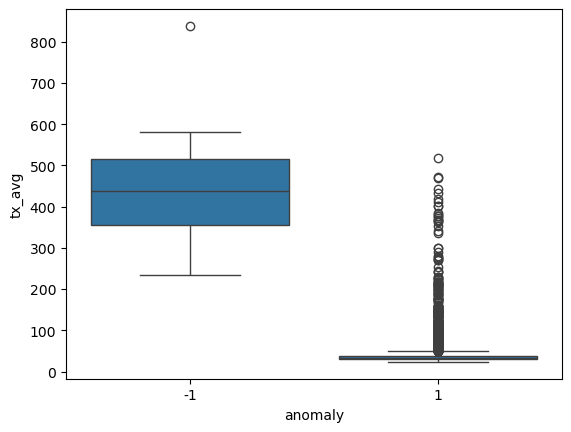

In [ ]:
import seaborn as sns
sns.boxplot(x='anomaly', y='tx_avg', data=features)

This creates a box plot comparing the distribution of `tx_avg` between:

- `anomaly = 1`: Accounts considered normal

- `anomaly = -1`: Accounts flagged as suspicious

### 🧠 Why We’re Doing This
We want to **interpret the model's decision-making** by comparing flagged accounts to typical behavior. Specifically, we're asking:

- Do flagged accounts have **significantly higher or lower transaction averages**?

- Are they outliers in how they move money?

If we see that flagged accounts have a different distribution from normal ones, it validates that the model is picking up on **behavioral differences**, not random noise.

## 📌 What the Output Tells Us
- Accounts flagged as **anomalies** (`-1`) tend to have **much higher average transaction values** compared to the rest.

- This is consistent with **check kiting behavior**, where <u>large transactions are cycled to create the illusion of available funds.</u>

- The **normal accounts** (`1`) cluster around much smaller average values, with many tightly packed low-amount users.

This gives us confidence that the model is identifying **high-value behavioral outliers**, which are good candidates for further investigation.

In the next step, we’ll explore other features like `tx_step_std` and `tx_amt_std` to further analyze what sets these accounts apart.

## 📊 Comparing Transaction Timing Variability (`tx_step_std`)

Now that we’ve seen average transaction amounts differ significantly between flagged and normal accounts, let’s examine another behavioral dimension: **transaction timing**.

Specifically, we’re looking at `tx_step_std` — the **standard deviation of the transaction step values** (i.e., how regularly the account transacts over time).

---

### 🧠 Why This Matters

In check kiting schemes, fraudsters often **repeat transactions in a predictable and mechanical pattern**. This reduces the standard deviation of the transaction steps — in other words, they make **transactions at regular intervals**.

If we observe **lower `tx_step_std` values** in flagged accounts, it could mean:
- The account is operating on a rigid schedule
- There may be **automated or scripted** behavior
- It’s a potential signal of **float exploitation** typical in check kiting

---

### 📌 What to Look For
Are `-1` (flagged) accounts less variable in their timing?

Is there a **visible separation** between the flagged and normal account distributions?

Do flagged accounts look like **behavioral outliers**, not just numerical anomalies?

After this, we’ll compare `tx_amt_std` (amount variability) to see whether flagged accounts are also repeating the **same amounts** — another classic sign of scripting and float manipulation.


<Axes: xlabel='anomaly', ylabel='tx_step_std'>

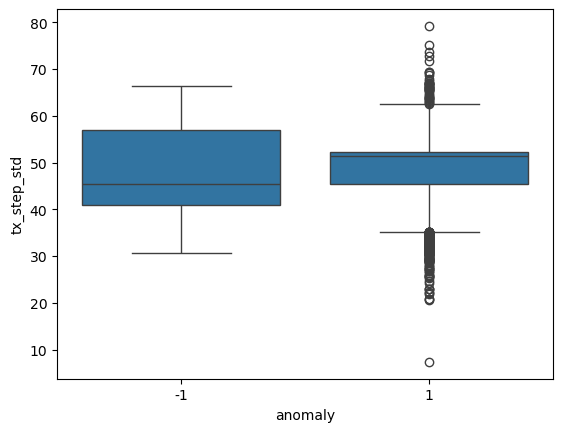

In [ ]:
sns.boxplot(x='anomaly', y='tx_step_std', data=features)

### 📊 Interpreting Transaction Timing Variability (`tx_step_std`)

This box plot compares **transaction step standard deviation** between flagged (`anomaly = -1`) and normal (`anomaly = 1`) accounts.




### 📌 What the Output Tells Us

- Flagged accounts (`-1`) show a **lower median `tx_step_std`** than normal accounts.
- This indicates that flagged accounts **transact more consistently** — with **less variation in timing**.
- Normal accounts (`1`) exhibit a **wider spread** and **more variability** in their transaction timing.
- This supports the hypothesis that **check kiting behavior is more structured**, with transactions happening on a **repeatable, possibly automated schedule** — consistent with efforts to **exploit float windows**.

---

### 🧠 Why This Is Useful

- Lower timing variability is a red flag for **synthetic behavior**.
- Consistent, clockwork-like activity often suggests a **non-human or fraud-driven intent**.
- This aligns well with what we expect from **float exploitation schemes**, where **precise timing is critical** to success.

> We’ve now seen how flagged accounts differ in both **average transaction size** and **transaction timing**.  
> In the next step, we’ll analyze **transaction amount variability** to complete the behavioral profile.


## 🎯 Goal: Visualize `tx_amt_std` (Transaction Amount Variability)
We want to see if anomalous accounts tend to have **low variability in transaction amounts**, which may suggest scripting or controlled float behavior. Fraudsters often use **fixed or repeat amounts** when cycling funds between accounts — a key behavioral flag in check kiting schemes.

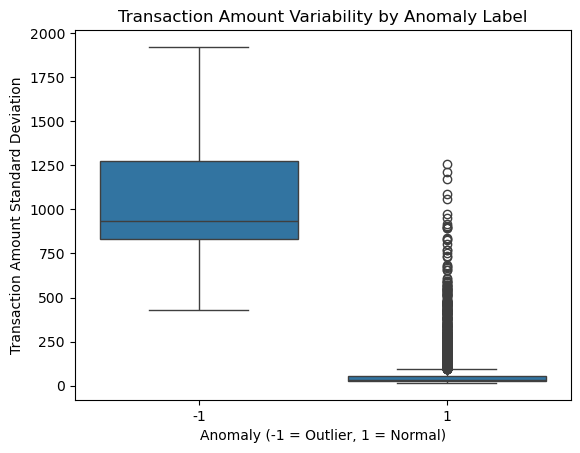

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot: Transaction amount variability by anomaly flag
sns.boxplot(x='anomaly', y='tx_amt_std', data=features)
plt.title('Transaction Amount Variability by Anomaly Label')
plt.xlabel('Anomaly (-1 = Outlier, 1 = Normal)')
plt.ylabel('Transaction Amount Standard Deviation')
plt.show()

### 📊 Transaction Amount Variability (`tx_amt_std`) by Anomaly Label

This plot helps us understand how **consistent or variable** the transaction amounts are for flagged vs. non-flagged accounts.



### 📌 What the Output Tells Us

- Flagged accounts (`-1`) have **significantly higher variability** in transaction amounts.
- Normal accounts (`1`) cluster around **very low standard deviations**, with many accounts making transactions of roughly the same value.
- This suggests that flagged accounts exhibit a **much broader range of transaction amounts** — possibly alternating between **large deposits and small withdrawals**, or vice versa.
- It may also indicate **staggered float manipulation**, where varying amounts are used to **mask systematic cycling behavior**.

---

### 🧠 Why This Is Useful

- While **low variability (`tx_amt_std`)** can suggest scripting, **high variability** in this dataset seems to **distinguish the most suspicious accounts**.
- This aligns with one form of **check kiting**, where the fraudster **tests float limits** by alternating values across cycles.
- Combined with the previously observed behaviors —  
  ✅ **High average amounts**  
  ✅ **Lower timing variability**  
  ✅ **Extreme amount variability**  

— this adds weight to the model’s decision and provides a **3-dimensional behavioral profile**.

> Together, these characteristics define the **behavioral fingerprint of likely check kiters** in this dataset.


In [ ]:
## ✅ Final Summary and Wrap-Up

In this project, we explored how **unsupervised machine learning** techniques can be used to detect **check kiting fraud**, a behavioral pattern that often goes unnoticed in transactional monitoring.

We used the `BankSim` dataset to simulate how real-world financial institutions might approach this problem.

---

### 🧠 What We Did

1. **Loaded and explored real-world financial data**
   - Identified extreme class imbalance (fraud rate ~1.2%)
   - Cleaned and encoded categorical variables

2. **Engineered customer-level behavioral features**
   - Total transaction count
   - Timing variability (`tx_step_std`)
   - Average and total amount
   - Amount variability (`tx_amt_std`)

3. **Trained an Isolation Forest model**
   - No labels were used for training (unsupervised)
   - Flagged 21 accounts as anomalies based on behavior

4. **Visualized and interpreted flagged accounts**
   - Flagged accounts showed:
     - **Higher average transaction amounts**
     - **Lower variability in transaction timing**
     - **Higher variability in transaction amounts**

---

### 📌 Key Takeaways

- **Check kiting is a behavioral fraud**, often missed by rule-based or supervised systems.
- **Isolation Forest** is a fast and scalable unsupervised method ideal for this type of detection.
- **Behavioral feature engineering is critical** — the model can only detect what you define and feed it.
- **Interpretability matters**: Through visualizations, we were able to understand and validate model behavior.

---

### 🧭 What Comes Next?

- **Human review** of flagged accounts for confirmation and investigation.
- Use this process to inform **risk scoring models** or **real-time alerting systems**.
- Extend this analysis by:
  - Adding time-series sequence models (e.g., LSTMs)
  - Integrating external data (e.g., device, location, login patterns)
  - Combining supervised and unsupervised approaches

---

> This demo showcased how data science can uncover hidden patterns in transactional data — giving fraud analysts a powerful head start against behavioral threats like check kiting.
